<a href="https://colab.research.google.com/github/MavinSao/Disaster-Tweets-ML/blob/main/FINAL_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#Loading the Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data_path = '/content/drive/MyDrive/CODE/Disaster-Tweets-ML'

In [4]:
train_df = pd.read_csv(f'{data_path}/dataset/train.csv')
test_df = pd.read_csv(f'{data_path}/dataset/test.csv')

#1. Exploratory Data Analysis (EDA) and Virtualizaiton

##1.1 Data Summary

In [5]:
# Display basic information about the dataset
print(train_df.info())

# Display summary statistics for numerical columns
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


In [6]:
# Display unique values and their counts for categorical columns
print(train_df['keyword'].value_counts())
print(train_df['location'].value_counts())

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64


##1.2 Handling Missing Data

In [7]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
# Example: Fill missing values in 'location' and 'keyword' with a 'no_keyword' and 'no_location'
train_df['keyword'].fillna('no_keyword', inplace=True)
train_df['location'].fillna('no_location', inplace=True)
train_df.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


##1.3 Exploring Target Distribution

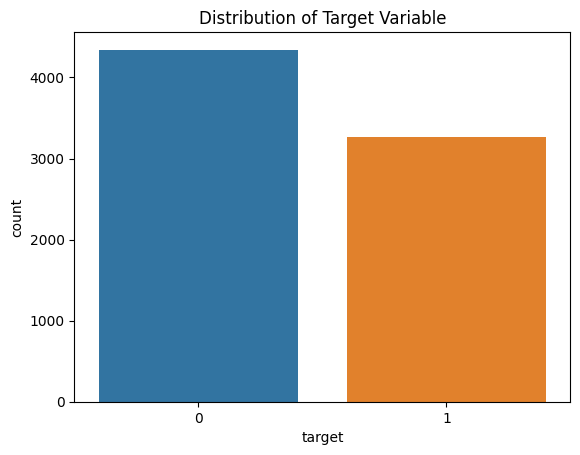

In [9]:
# Visualize the distribution of the target variable
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

##1.4 Analyzing Text Data

In [10]:
import re
# Function to clean and preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Remove punctuation and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    return text

In [11]:
import nltk
from nltk.corpus import stopwords

disaster_tweets = train_df[train_df['target'] == 1]['text']
non_disaster_tweets = train_df[train_df['target'] == 0]['text']

# Download NLTK stopwords data (only need to do this once)
nltk.download('stopwords')

# Define custom stopwords to add to the existing NLTK stopwords list
custom_stopwords = set(['co', 't', 'https', 'amp', 'u', 'im', 'new', 'one', 'us', 'via'])  # Add your custom stopwords here

# Remove stopwords
stop_words = set(stopwords.words('english') + list(custom_stopwords))

cleaned_disaster_tweets = disaster_tweets.apply(preprocess_text)
cleaned_non_disaster_tweets = non_disaster_tweets.apply(preprocess_text)

cleaned_disaster_tweets = cleaned_disaster_tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
cleaned_non_disaster_tweets = cleaned_non_disaster_tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


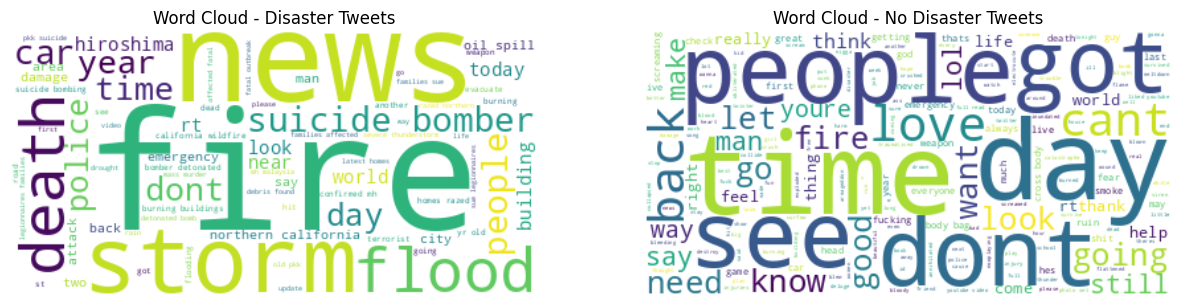

In [12]:
# Example: Word cloud for disaster and non-disaster tweets
from wordcloud import WordCloud

# Create a word cloud for disaster tweets
wordcloud_disaster = WordCloud(width=400, height=200, background_color='white').generate(' '.join(cleaned_disaster_tweets))

# Create a word cloud for non-disaster tweets
wordcloud_non_disaster = WordCloud(width=400, height=200, background_color='white').generate(' '.join(cleaned_non_disaster_tweets))

# Plot side by side
plt.figure(figsize=(15, 5))

# Plot for disaster tweets
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Word Cloud - Disaster Tweets')
plt.axis('off')

# Plot for non-disaster tweets
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Word Cloud - No Disaster Tweets')
plt.axis('off')

plt.show()

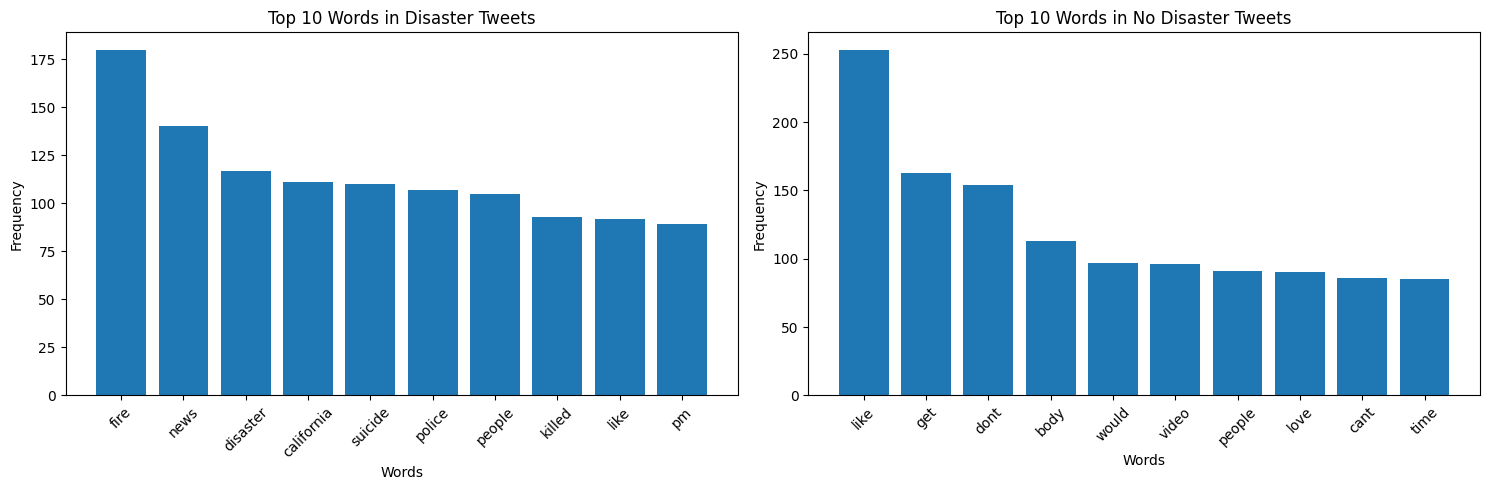

In [13]:
from collections import Counter

# Assuming you have the cleaned text data for disaster and non-disaster tweets
cleaned_disaster_text = ' '.join(cleaned_disaster_tweets)
cleaned_non_disaster_text = ' '.join(cleaned_non_disaster_tweets)

# Function to get the top N words from text
def get_top_words(text, n=10):
    words = text.split()
    word_counts = Counter(words)
    top_words = word_counts.most_common(n)
    return top_words

# Get the top 10 words for disaster tweets
top_disaster_words = get_top_words(cleaned_disaster_text, n=10)
# Get the top 10 words for non-disaster tweets
top_non_disaster_words = get_top_words(cleaned_non_disaster_text, n=10)

# Function to plot top N words
def plot_top_words(ax, top_words, title):
    words, counts = zip(*top_words)
    ax.bar(words, counts)
    ax.set_title(title)
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot top words for disaster tweets
plot_top_words(axes[0], top_disaster_words, 'Top 10 Words in Disaster Tweets')

# Plot top words for non-disaster tweets
plot_top_words(axes[1], top_non_disaster_words, 'Top 10 Words in No Disaster Tweets')

# Adjust layout
plt.tight_layout()
plt.show()

##1.5 Exploring Keyword and Location Columns

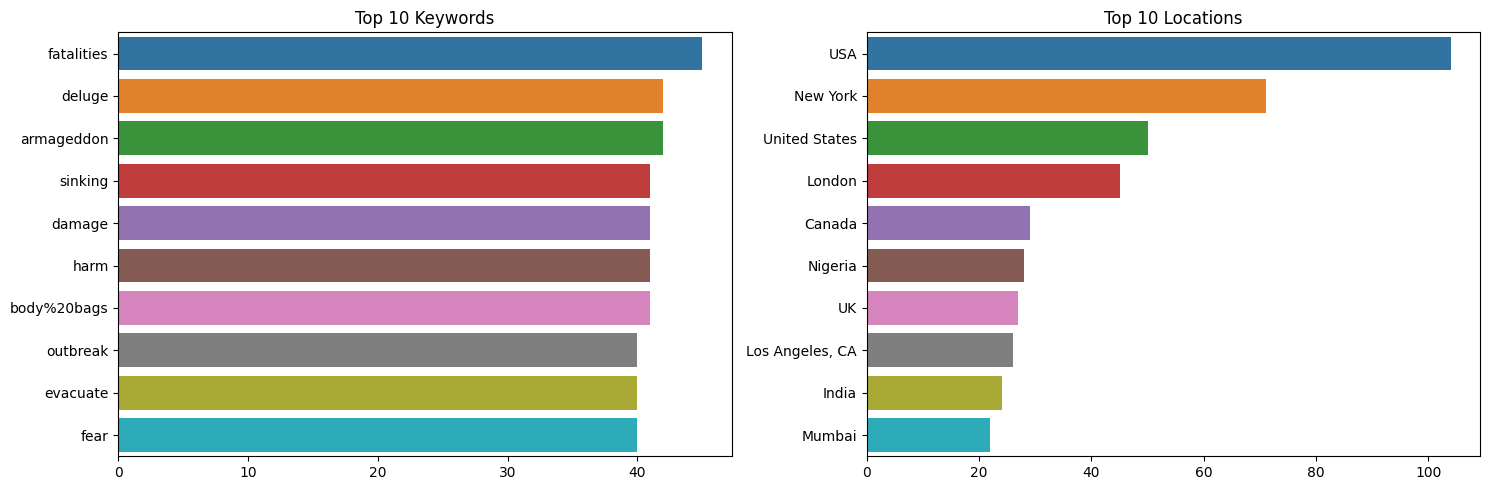

In [14]:
# Explore the 'location' column, excluding 'no_location'
location_filtered_df = train_df[train_df['location'] != 'no_location']
keyword_filtered_df = train_df[train_df['keyword'] != 'no_keyword']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot top keywords
top_keywords = keyword_filtered_df['keyword'].value_counts().nlargest(10)
sns.barplot(x=top_keywords.values, y=top_keywords.index, ax=axes[0])
axes[0].set_title('Top 10 Keywords')

# Plot top locations
top_locations = location_filtered_df['location'].value_counts().nlargest(10)
sns.barplot(x=top_locations.values, y=top_locations.index, ax=axes[1])
axes[1].set_title('Top 10 Locations')

# Adjust layout
plt.tight_layout()
plt.show()

#2. Baseline Models

##2.1 Load Data

In [15]:
#Load Data
#Drop unused columns
df = train_df
#Clean Data
cleaned_text = df['text'].apply(preprocess_text)
df['text'] = cleaned_text.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,deeds reason earthquake may allah forgive,1
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1
2,5,no_keyword,no_location,residents asked shelter place notified officer...,1
3,6,no_keyword,no_location,people receive wildfires evacuation orders cal...,1
4,7,no_keyword,no_location,got sent photo ruby alaska smoke wildfires pou...,1


## 2.2 TFIDF + LogReg

In [16]:
# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.3, random_state=42, stratify=df['target'])

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Build a logistic regression model
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_tfidf, y_train)

# Make predictions
lr_predictions = lr_classifier.predict(X_test_tfidf)

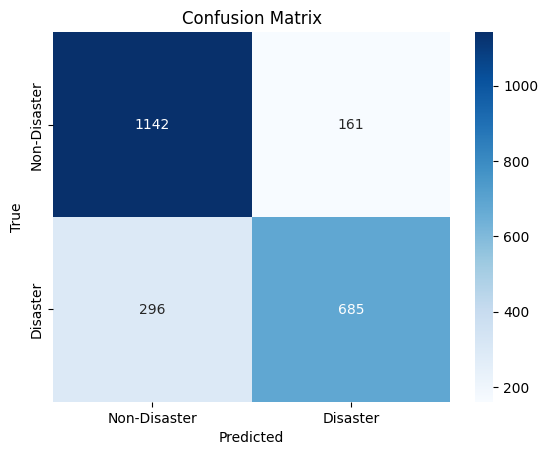


Accuracy: 0.7999124343257443
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1303
           1       0.81      0.70      0.75       981

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [17]:
# Generate and print the confusion matrix

def eval_matrix(eval_labels, predictions):

  conf_matrix = confusion_matrix(eval_labels, predictions)

  # Plot the confusion matrix
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  # Evaluate the model
  accuracy = accuracy_score(eval_labels, predictions)
  report = classification_report(eval_labels, predictions)

  print(f"\nAccuracy: {accuracy}")
  print("Classification Report:")
  print(report)

#LR
eval_matrix(y_test, lr_predictions)

##2.3 Naive Bayes

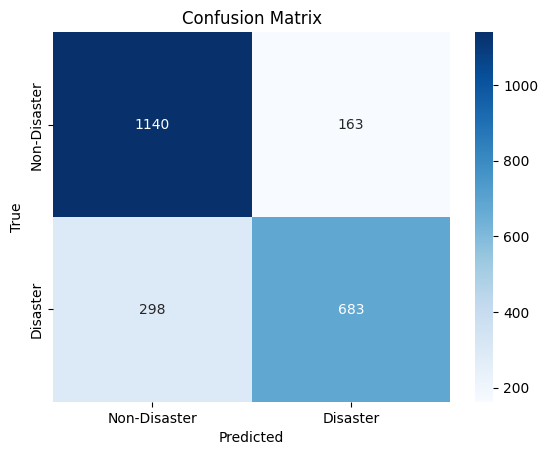


Accuracy: 0.7981611208406305
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1303
           1       0.81      0.70      0.75       981

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [18]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train a Multinomial Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
nb_predict = naive_bayes_model.predict(X_test_tfidf)

#Naive Bayes
eval_matrix(y_test, nb_predict)

##2.4 Support Vector Machines

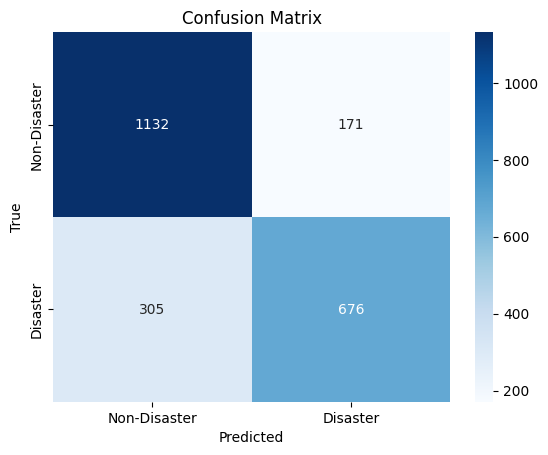


Accuracy: 0.7915936952714536
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1303
           1       0.80      0.69      0.74       981

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284



In [19]:
from sklearn.svm import SVC

# Initialize and train a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear')  # You can try different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
svm_pridict = svm_model.predict(X_test_tfidf)

#Plot
eval_matrix(y_test, svm_pridict)


##2.5 LSTM

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report

# Tokenize and pad the sequences
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 200  # Set the maximum sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Make predictions on the test set
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int)

Epoch 1/5
167/167 [==============================] - 19s 92ms/step - loss: 0.5439 - accuracy: 0.7313 - val_loss: 0.4412 - val_accuracy: 0.8113
Epoch 2/5
167/167 [==============================] - 3s 20ms/step - loss: 0.3344 - accuracy: 0.8578 - val_loss: 0.4679 - val_accuracy: 0.7968
Epoch 3/5
167/167 [==============================] - 3s 20ms/step - loss: 0.3185 - accuracy: 0.8835 - val_loss: 0.5236 - val_accuracy: 0.7828
Epoch 4/5
167/167 [==============================] - 3s 17ms/step - loss: 0.2040 - accuracy: 0.9202 - val_loss: 0.6170 - val_accuracy: 0.7802
Epoch 5/5
72/72 [==============================] - 1s 4ms/step


In [22]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1303
           1       0.75      0.70      0.73       981

    accuracy                           0.77      2284
   macro avg       0.77      0.76      0.77      2284
weighted avg       0.77      0.77      0.77      2284



##2.6 Baseline Comparation

| Baseline      | precision | recall | f1    | accuracy |
| ------------- | --------- | ------ | ----- | ----- |
| LR            | 0.79      | **0.88**   | 0.83  | 0.80 |
| NB            | 0.79      | 0.87   | 0.83  | 0.80 |
| SVM           | 0.79      | 0.87   | 0.83  | *0.79* |

#3. Improve Baseline

## 3.1 Combine Text and Keyword Features
Concatenate the 'text' and 'keyword' columns to create a new feature that captures information from both. This way, you'll have a more comprehensive representation of the input data.

###3.1.1 Load Data

In [23]:
# Load Data
df = pd.read_csv(f'{data_path}/dataset/train.csv')
#Clean Data
cleaned_text = df['text'].apply(preprocess_text)
df['text'] = cleaned_text.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [24]:
#Create text_with_keyword columns
df_CF = df.copy()

df_CF['text_with_keyword'] = df['text'] + ' ' + df['keyword'].fillna('')
df_CF.head()

,id,keyword,location,text,target,text_with_keyword
0,1,NaN,NaN,deeds reason earthquake may allah forgive,1,deeds reason earthquake may allah forgive
1,4,NaN,NaN,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,residents asked shelter place notified officer...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,got sent photo ruby alaska smoke wildfires pou...


###3.1.2 Logistic Regression

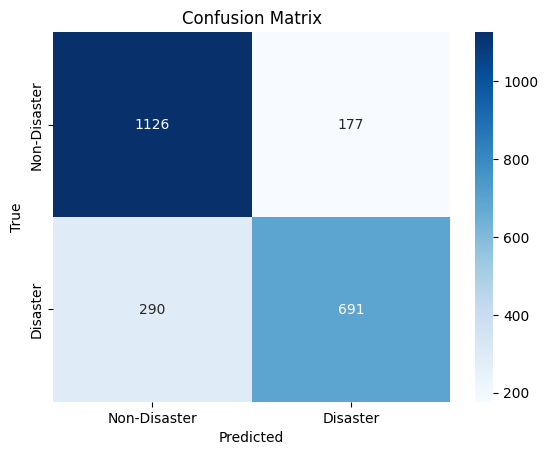


Accuracy: 0.7955341506129597
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1303
           1       0.80      0.70      0.75       981

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284



In [25]:
# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(df_CF['text_with_keyword'], df_CF['target'], test_size=0.3, random_state=42, stratify=df_CF['target'])

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Build a logistic regression model
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_tfidf, y_train)

# Make predictions
lr_predictions = lr_classifier.predict(X_test_tfidf)

# Generate and print the confusion matrix

def eval_matrix(eval_labels, predictions):

  conf_matrix = confusion_matrix(eval_labels, predictions)

  # Plot the confusion matrix
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  # Evaluate the model
  accuracy = accuracy_score(eval_labels, predictions)
  report = classification_report(eval_labels, predictions)

  print(f"\nAccuracy: {accuracy}")
  print("Classification Report:")
  print(report)

#LR
eval_matrix(y_test, lr_predictions)

###3.1.3 Naive Bayes

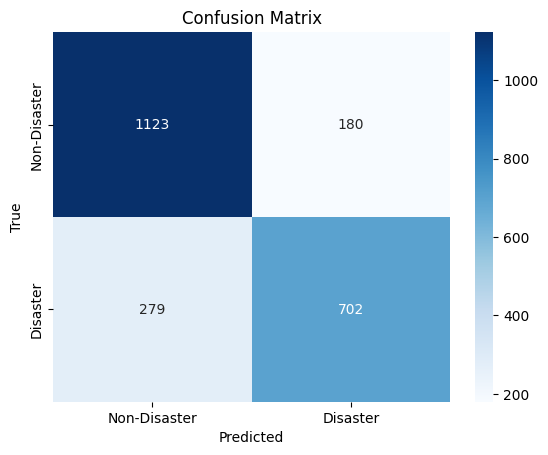


Accuracy: 0.7990367775831874
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1303
           1       0.80      0.72      0.75       981

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [26]:
# Initialize and train a Multinomial Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
nb_predictions = naive_bayes_model.predict(X_test_tfidf)

#Naive Bayes
eval_matrix(y_test, nb_predictions)

###3.1.4 SVM

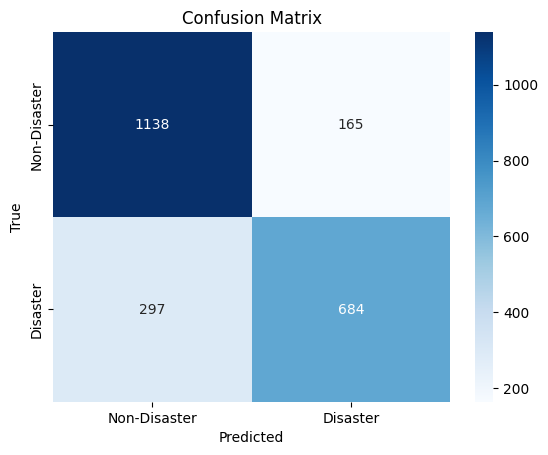


Accuracy: 0.797723292469352
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1303
           1       0.81      0.70      0.75       981

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [27]:
from sklearn.svm import SVC

# Initialize and train a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear')  # You can try different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
svm_pridict = svm_model.predict(X_test_tfidf)

#Plot
eval_matrix(y_test, svm_pridict)

###3.1.5 Combine Text and Keyword Features Comparison

| Combine Text and Keyword      | precision | recall | f1    | accuracy |
| ------------- | --------- | ------ | ----- | ----- |
| LR            | 0.80      | 0.86   | 0.83  | 0.80 |
| NB            | 0.80      | 0.86   | 0.83  | 0.80 |
| SVM           | *0.79*      | **0.87**   | 0.83  | 0.80 |

##3.2 Feature Engineering
Extract relevant information from the 'keyword' column and create new features. For example, you might create binary indicators for specific keywords or perform one-hot encoding.

###3.2.1 Load Data

In [33]:
df_FE = df.copy()

# Example: Creating binary indicators for specific keywords
# Filter rows where the target is 1
disaster_rows = df_FE[df_FE['target'] == 1]

# Create a set of disaster keywords without NaN values
disaster_keywords = set(disaster_rows['keyword'].dropna())

# Create binary indicator based on the presence of any disaster keyword
df_FE['has_disaster_keyword'] = df_FE['text'].apply(lambda x: 1 if any(keyword in x for keyword in disaster_keywords) else 0)

###3.2.2 Logistic Regression

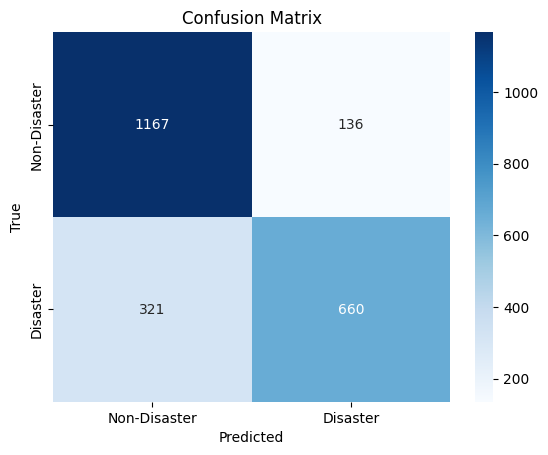


Accuracy: 0.7999124343257443
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1303
           1       0.83      0.67      0.74       981

    accuracy                           0.80      2284
   macro avg       0.81      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [34]:
from scipy.sparse import hstack  # Import the hstack function

X = df_FE[['text', 'has_disaster_keyword']]
y = df_FE['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# TF-IDF vectorization for 'text_with_keyword'
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['text'])

# Combine TF-IDF features with 'has_disaster_keyword' column
X_train_combined = hstack([X_train_tfidf, X_train['has_disaster_keyword'].values.reshape(-1, 1)])
X_test_combined = hstack([X_test_tfidf, X_test['has_disaster_keyword'].values.reshape(-1, 1)])

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_combined, y_train)

# Make predictions
predictions = model.predict(X_test_combined)

# Display classification report
eval_matrix(y_test, predictions)


###3.2.3 Naive Base

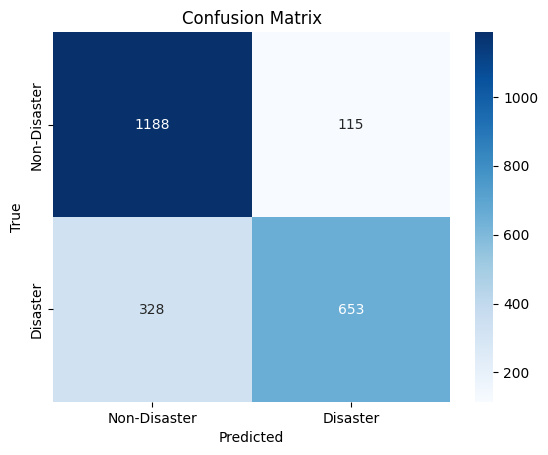


Accuracy: 0.8060420315236427
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1303
           1       0.85      0.67      0.75       981

    accuracy                           0.81      2284
   macro avg       0.82      0.79      0.79      2284
weighted avg       0.81      0.81      0.80      2284



In [35]:
# Initialize and train a Multinomial Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_combined, y_train)

# Make predictions on the test set
predictions = naive_bayes_model.predict(X_test_combined)

#Naive Bayes
eval_matrix(y_test, predictions)

###3.2.4 SVM

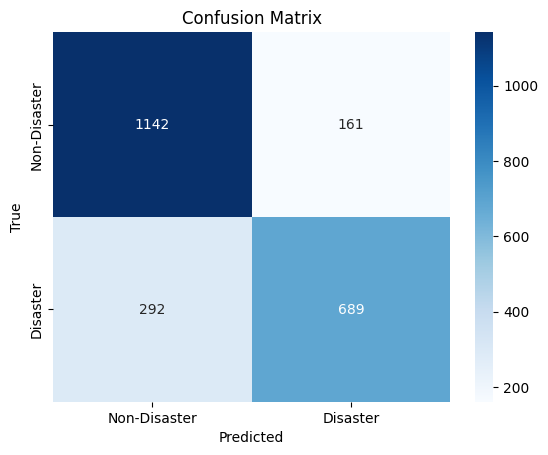


Accuracy: 0.8016637478108581
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1303
           1       0.81      0.70      0.75       981

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [36]:
from sklearn.svm import SVC

# Initialize and train a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear')  # You can try different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train_combined, y_train)

# Make predictions on the test set
svm_pridict = svm_model.predict(X_test_combined)

#Plot
eval_matrix(y_test, svm_pridict)

###3.2.5 Feature Engineering Comparison

| Feature Engineering      | precision | recall | f1    | accuracy |
| ------------- | --------- | ------ | ----- | ----- |
| LR            | 0.78      | 0.90   | 0.84  | 0.80 |
| NB            | 0.78      | **0.91**   | 0.84  | **0.81** |
| SVM           | **0.80**      | 0.88   | *0.83*  | 0.80 |

## 3.2 TF-IDF Vectorization for Multiple Columns
Use TF-IDF vectorization on both the 'text' and 'keyword' columns separately and then combine the resulting sparse matrices.

###3.2.1 Load Data

In [37]:
df_TV = df.copy()

# TF-IDF vectorization for text
tfidf_text = TfidfVectorizer().fit_transform(df_TV['text'])

# TF-IDF vectorization for keyword
tfidf_keyword = TfidfVectorizer().fit_transform(df_TV['keyword'].fillna(''))

# Combine the sparse matrices
combined_tfidf = hstack([tfidf_text, tfidf_keyword])

combined_tfidf

<7613x16979 sparse matrix of type '<class 'numpy.float64'>'
	with 74659 stored elements in Compressed Sparse Row format>

###3.2.2 Logistic Regression

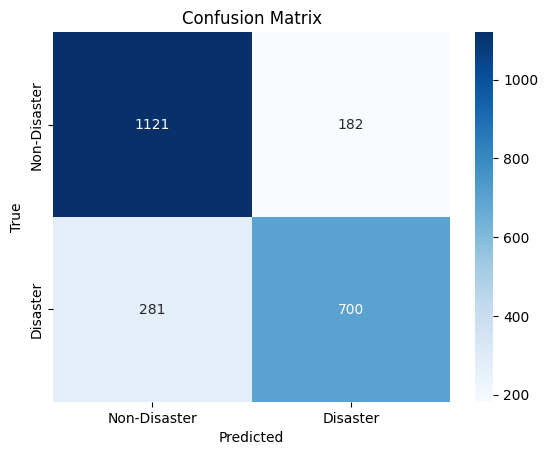


Accuracy: 0.7972854640980735
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1303
           1       0.79      0.71      0.75       981

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [38]:
X_train, X_test, y_train, y_test = train_test_split(combined_tfidf, df_TV['target'], test_size=0.3, random_state=42, stratify=df_TV['target'])

# Initialize and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
eval_matrix(y_test, predictions)

###3.2.3 Naive Bayes

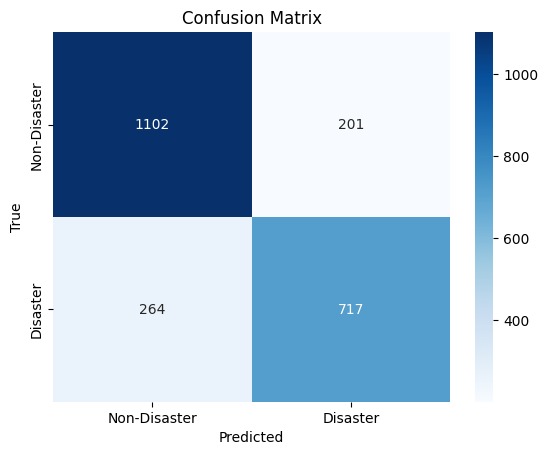


Accuracy: 0.7964098073555166
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1303
           1       0.78      0.73      0.76       981

    accuracy                           0.80      2284
   macro avg       0.79      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [39]:
# Initialize and train a Multinomial Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = naive_bayes_model.predict(X_test)

#Naive Bayes
eval_matrix(y_test, predictions)

###3.2.4 SVM

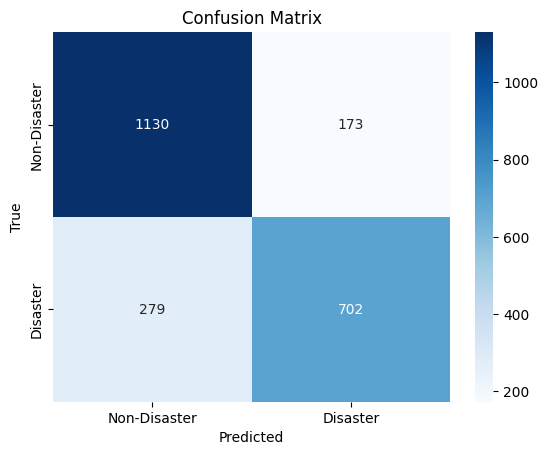


Accuracy: 0.8021015761821366
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1303
           1       0.80      0.72      0.76       981

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [40]:
from sklearn.svm import SVC

# Initialize and train a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear')  # You can try different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Make predictions on the test set
svm_pridict = svm_model.predict(X_test)

#Plot
eval_matrix(y_test, svm_pridict)

###3.2.5 TF-IDF Vectorization for Multiple Columns Comparision

| TF-IDF Vectorization for Multiple Columns | precision | recall | f1    | accuracy |
| ------------- | --------- | ------ | ----- | ----- |
| LR            | 0.80      | 0.86   | 0.83  | 0.80 |
| NB            | 0.80      | 0.85   | 0.83  | 0.80 |
| SVM           | 0.80      | **0.87**   | 0.83  | 0.80 |

#4. Summarization and Conclusion


## All Results


<table>
<tr><th> Baseline Table </th> <th>Combine Text and Keyword Features </th><th> Feature Engineering </th><th> TF-IDF Vectorization for Multiple Columns </th></tr>

<tr><td>

| Baseline      | precision | recall | f1    | accuracy |
| ------------- | --------- | ------ | ----- | ----- |
| LR            | 0.79      | 0.88   | 0.83  | 0.80 |
| NB            | 0.79      | 0.87   | 0.83  | 0.80 |
| SVM           | 0.79      | 0.87   | 0.83  | *0.79* |

</td><td>

| Combine Text and Keyword      | precision | recall | f1    | accuracy |
| ------------- | --------- | ------ | ----- | ----- |
| LR            | ***0.80***  | 0.86   | 0.83  | 0.80 |
| NB            | 0.80      | 0.86   | 0.83  | 0.80 |
| SVM           | *0.79*      | **0.87**   | 0.83  | 0.80 |

</td><td>

| Feature Engineering      | precision | recall | f1    | accuracy |
| ------------- | --------- | ------ | ----- | ----- |
| LR            | 0.78      | **0.90**   | **0.84** | 0.80 |
| NB            | 0.78      | **0.91**   | 0.84  | **0.81** |
| SVM           | **0.80**      | 0.88   | *0.83*  | 0.80 |

</td><td>

| TF-IDF Vectorization for Multiple Columns | precision | recall | f1    | accuracy |
| ------------- | --------- | ------ | ----- | ----- |
| LR            | ***0.80***     | 0.86   | 0.83  | 0.80 |
| NB            | 0.80      | 0.85   | 0.83  | 0.80 |
| SVM           | 0.80      | **0.87**   | 0.83  | 0.80 |

</td></tr> </table>


## Improvement Comparision

<table>
<tr><th> Accuracy Improvement </th> <th>Precision Improvement </th></tr>

<tr><td>


| Model     | Baseline | Combine Text and Keyword | Feature Engineering | TF-IDF Vectorization    |
|-----------|----------|---------------------------|----------------------|-----------------------|
| **LR**    | 0.80     | 0.80                      | 0.80                 | 0.80                  |
| **NB**    | 0.80     | 0.80                      | ***0.81***           | 0.80                  |
| **SVM**   | *0.79*   | 0.80                      | 0.80                 | 0.80                  |


</td><td>

| Model     | Baseline | Combine Text and Keyword | Feature Engineering | TF-IDF Vectorization |
|-----------|----------|---------------------------|----------------------|-----------------------|
| **LR**    | 0.79     | **0.80**                  | 0.78                 | **0.80**          |
| **NB**    | 0.79     | **0.80**                  | 0.78                 | **0.80**          |
| **SVM**   | 0.79     | 0.79                      | **0.80**             | **0.80**          |      

</td></tr>
<tr><th> Recall Improvement </th><th> F1 Improvement </th></tr>
<tr><td>

| Model     | Baseline | Combine Text and Keyword | Feature Engineering | TF-IDF Vectorization |
|-----------|----------|---------------------------|----------------------|-----------------------|
| **LR**    | 0.88     | 0.86                      | ***0.90***                | 0.86             |
| **NB**    | 0.87     | 0.86                      | ***0.91***                | *0.85*           |
| **SVM**   | 0.87     | 0.87                      | ***0.88***                | 0.87             |

</td><td>

| Model     | Baseline | Combine Text and Keyword | Feature Engineering | TF-IDF Vectorization |
|-----------|----------|---------------------------|----------------------|-----------------------|
| **LR**    | 0.83     | 0.83                      | **0.84**             | 0.83                  |
| **NB**    | 0.83     | 0.83                      | **0.84**             | 0.83                  |
| **SVM**   | 0.83     | 0.83                      | 0.83                 | 0.83                  |


</td></tr> </table>


## Result Summarization

### Accuracy Improvement:
- Naive Bayes (NB) achieved a slight improvement in accuracy compared to the baseline, reaching 0.81 on Feature Engineering technique.
- SVM showed a marginal improvement from the baseline (0.79), reaching an accuracy of 0.80 on every techniques.
- Maintained Accuracy: Logistic Regression (LR) and Support Vector Machine (SVM) maintained the baseline accuracy of 0.80.

### Precision Improvement
- LR, NB, and SVM all demonstrated precision improvement compared to the baseline, with scores of 0.80.
- For Feature Engineering Technique both LR and NB downgrade to (0.78) compare to baseline (0.79)

### Recall Improvement
- LR demonstrated a recall improvement from the baseline (0.88), achieving a score of 0.90 on Feature Engineering technique.
- NB also showed recall improvement, reaching a score of 0.91 on Feature Engineering technique.
- SVM exhibited recall improvement, achieving a score of 0.88 on Feature Engineering technique.

###F1 Improvement
- LR demonstrated an F1 improvement from the baseline, achieving a score of 0.84 on Feature Engineering technique.
- NB also showed F1 improvement, reaching a score of 0.84 on the same technique.
- SVM did not show F1 improvement compared to the baseline, maintaining a score of 0.83.

##Conclusion
Base on the results of performance(Accuracy, Precision, Recall, and F1) we will choose Naive Bayes (NB) with Feature Engineering technique for the competition. Because, NB showed improvement in accuracy, precision, recall, and F1 score. Feature Engineering enhanced its overall performance.


